# Fase D: Análisis Estratégico Integral (Tienda + Entorno + Producto)

## Resumen Ejecutivo del Proyecto hasta el momento
1.  **Fase A (EDA):** Entendimos la distribución de datos y detectamos nulos.
2.  **Fase B (Feature Eng):** Limpiamos y creamos un dataset a nivel producto único.
3.  **Fase C (Clustering):** Agrupamos productos en 4 clusters clave (Drinks, Food Economy, Food Premium, Non-Edible).

## Objetivos de esta Notebook (Fase D - Iteración Final)
Esta notebook consolida todo el análisis de negocio para alimentar el Dashboard de la Fase E. Abordaremos 3 dimensiones:

1.  **Dimensión Tienda (Store DNA):** 
    * Validar que el Mix de productos es homogéneo (Estandarización).
    * Confirmar que la diferenciación viene por **Escala** (Volumen de ventas) y **Eficiencia**.
2.  **Dimensión Estratégica (Precio):**
    * Analizar la sensibilidad al precio. (Validamos previamente que Premium vende más en promedio, incluso en Grocery Stores).
3.  **Dimensión Entorno y Operación (Nuevos Insights):**
    * **Evolución:** Crecimiento de tiendas en el tiempo.
    * **Geografía:** Distribución de formatos por tipo de ciudad.
    * **Visibilidad:** Impacto real de la exhibición en las ventas.

## Entregable
Un archivo JSON jerárquico (`store_hierarchy_final.json`) listo para D3.js que contiene toda esta inteligencia de negocio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Rutas de archivos
RAW_DATA_PATH = '../Data/Raw/train.csv'
CLUSTERS_PATH = '../Data/Processed/product_level_with_clusters.csv'

print("✅ Entorno listo. Iniciando análisis integral.")

✅ Entorno listo. Iniciando análisis integral.


---
## 1. Integración de Datos y Segmentación de Precios

Unimos las transacciones con los clusters y creamos la segmentación de precios (Economy/Standard/Premium) que resultó ser un hallazgo clave.

In [2]:
# 1. Carga
df_trans = pd.read_csv(RAW_DATA_PATH)
df_clusters = pd.read_csv(CLUSTERS_PATH)

# 2. Merge
cols_cluster = ['Item_Identifier', 'Cluster_Label', 'Broad_Category', 'Avg_Visibility'] 
# Nota: Traemos Avg_Visibility del cluster para comparar vs la real de la tienda
df_merged = df_trans.merge(df_clusters[cols_cluster], on='Item_Identifier', how='left')

# 3. Price Tiers (Feature Engineering)
quartiles = df_merged['Item_MRP'].quantile([0.33, 0.66]).values
def classify_price(mrp):
    if mrp < quartiles[0]: return 'Economy'
    elif mrp < quartiles[1]: return 'Standard'
    else: return 'Premium'

df_merged['Price_Tier'] = df_merged['Item_MRP'].apply(classify_price)

print(f"Dataset Integrado: {df_merged.shape}")
df_merged.head(2)

Dataset Integrado: (8523, 16)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Cluster_Label,Broad_Category,Avg_Visibility,Price_Tier
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14,Food: Mass Market / High Rev,Food,0.02,Premium
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42,Drinks,Drinks,0.02,Economy


---
## 2. Dimensión Tienda: DNA, Escala y Eficiencia

Replicamos los gráficos que confirmaron que **"Todos venden lo mismo (Mix), pero a escalas muy diferentes"**.

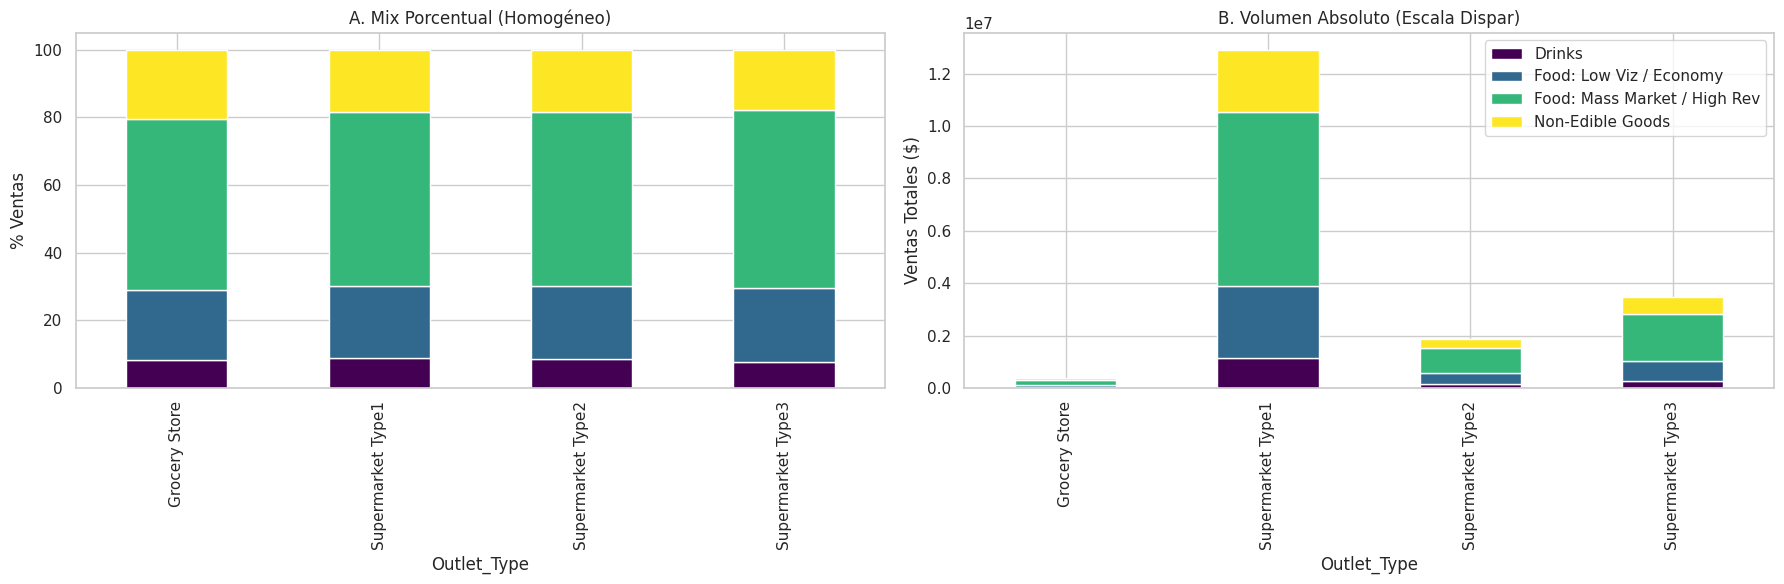

In [3]:
# Preparación de datos agregados
store_sales = df_merged.groupby(['Outlet_Identifier', 'Cluster_Label'])['Item_Outlet_Sales'].sum().reset_index()
df_absolute = store_sales.pivot(index='Outlet_Identifier', columns='Cluster_Label', values='Item_Outlet_Sales').fillna(0)
df_absolute['Total_Sales'] = df_absolute.sum(axis=1)

# Datos Relativos (%)
cluster_cols = [c for c in df_absolute.columns if c != 'Total_Sales']
df_relative = df_absolute[cluster_cols].div(df_absolute['Total_Sales'], axis=0) * 100

# Metadata
store_meta = df_merged[['Outlet_Identifier', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Establishment_Year']].drop_duplicates().set_index('Outlet_Identifier')
df_dna = df_absolute.join(store_meta)

# Visualización Dual (Mix vs Escala)
sum_mix_absolute = df_absolute.join(store_meta['Outlet_Type']).groupby('Outlet_Type').sum()
avg_mix_relative = df_relative.join(store_meta['Outlet_Type']).groupby('Outlet_Type').mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
avg_mix_relative.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('A. Mix Porcentual (Homogéneo)')
axes[0].set_ylabel('% Ventas')
axes[0].get_legend().remove()

sum_mix_absolute.drop('Total_Sales', axis=1).plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('B. Volumen Absoluto (Escala Dispar)')
axes[1].set_ylabel('Ventas Totales ($)')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

---
## 3. Dimensión Estratégica: El Poder de lo Premium

Validamos tu hallazgo visual: **Los productos Premium generan más revenue promedio por unidad en TODOS los formatos**, aunque la Grocery Store tenga un volumen total bajo.

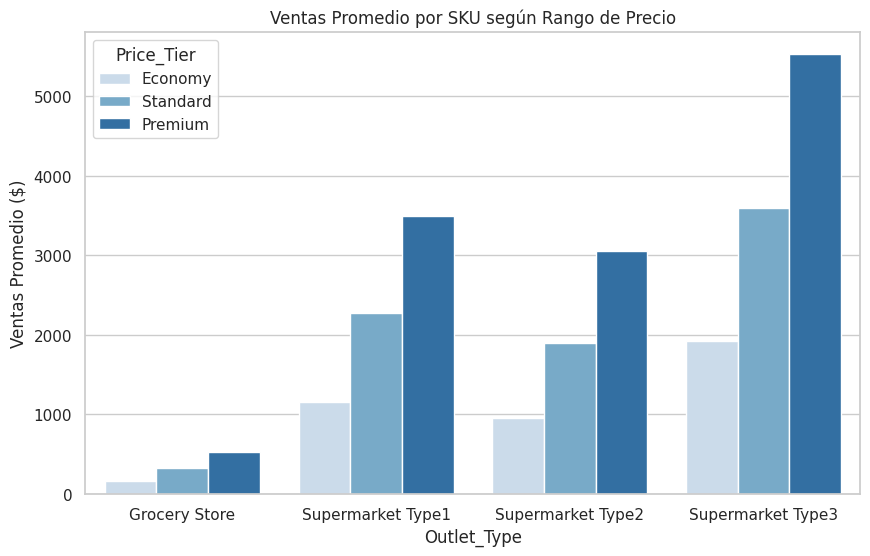

In [4]:
price_sensitivity = df_merged.groupby(['Outlet_Type', 'Price_Tier'])['Item_Outlet_Sales'].mean().reset_index()
order = ['Economy', 'Standard', 'Premium']

plt.figure(figsize=(10, 6))
sns.barplot(x='Outlet_Type', y='Item_Outlet_Sales', hue='Price_Tier', hue_order=order, data=price_sensitivity, palette='Blues')
plt.title('Ventas Promedio por SKU según Rango de Precio')
plt.ylabel('Ventas Promedio ($)')
plt.show()

---
## 4. Dimensión Entorno: Tiempo y Espacio (Nuevos Requerimientos)

Aquí respondemos las nuevas preguntas:
1.  **Evolución:** ¿Cómo crecieron los formatos en el tiempo?
2.  **Distribución:** ¿Qué tiendas hay en cada ciudad?

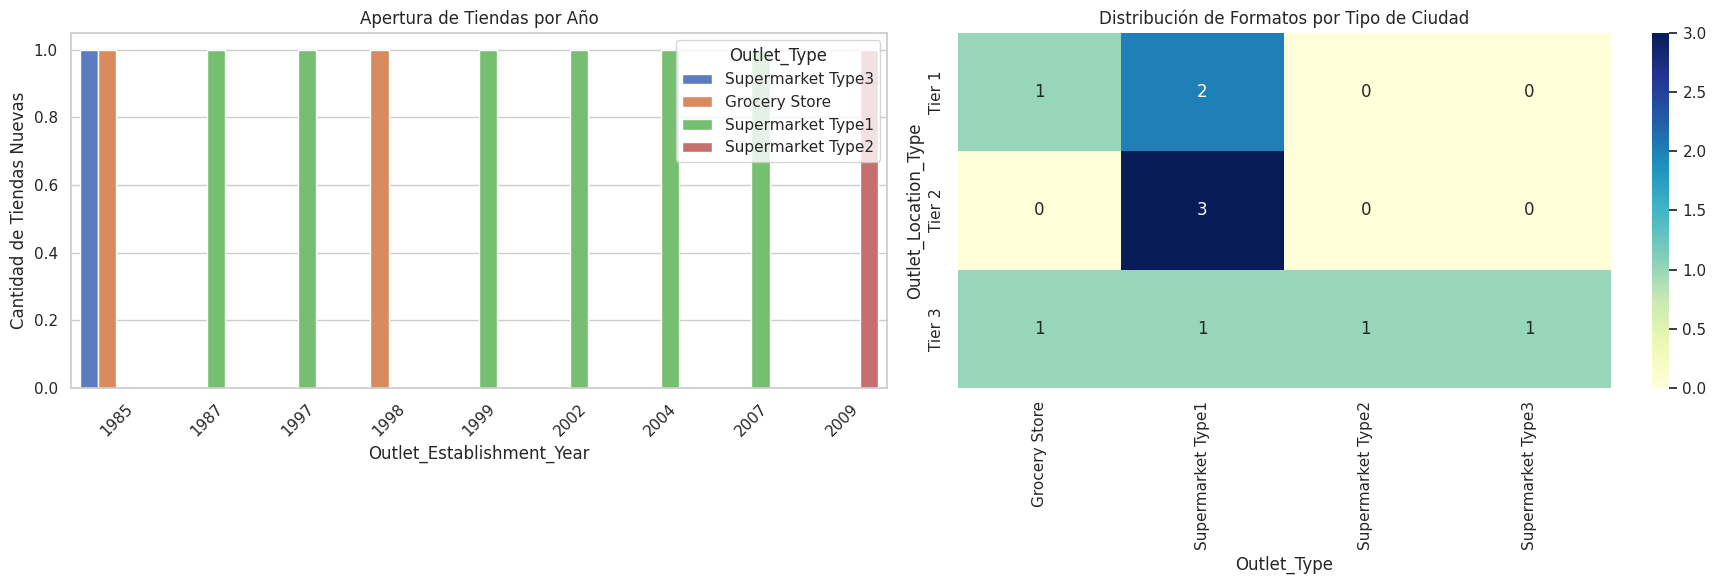

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 4.1 Crecimiento de Tiendas (Countplot por Año)
# Nota: Esto muestra cuándo se fundaron las tiendas existentes.
sns.countplot(x='Outlet_Establishment_Year', hue='Outlet_Type', data=df_merged.drop_duplicates(subset=['Outlet_Identifier']), ax=axes[0], palette='muted')
axes[0].set_title('Apertura de Tiendas por Año')
axes[0].set_ylabel('Cantidad de Tiendas Nuevas')
axes[0].tick_params(axis='x', rotation=45)

# 4.2 Distribución por Tipo de Ciudad (Heatmap)
city_store_matrix = pd.crosstab(store_meta['Outlet_Location_Type'], store_meta['Outlet_Type'])
sns.heatmap(city_store_matrix, annot=True, fmt='d', cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Distribución de Formatos por Tipo de Ciudad')

plt.tight_layout()
plt.show()

### Insights de Entorno
* **Evolución:** Hubo un pico de expansión en 1985 (muchas Grocery Stores y Supermarket Type3). Luego una pausa y reactivación a finales de los 90s con Supermarket Type1.
* **Geografía:**
    * **Tier 2** es territorio exclusivo de `Supermarket Type1`.
    * **Tier 3** es el más diverso: Tiene todos los tipos (Grocery, Type1, Type2, Type3).
    * **Tier 1** mezcla Grocery y Type1.
    * *Insight:* Tier 3 parece ser el mercado de prueba o el más saturado.

---
## 5. Dimensión Operativa: Visibilidad y Ventas

Preguntas a responder:
1.  ¿El tamaño de la tienda influye en la visibilidad?
2.  ¿Más visibilidad = Más ventas?

/tmp/ipykernel_909815/918682932.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outlet_Size', y='Item_Visibility', data=df_merged, order=['Small', 'Medium', 'High'], ax=axes[0], palette='Set2')


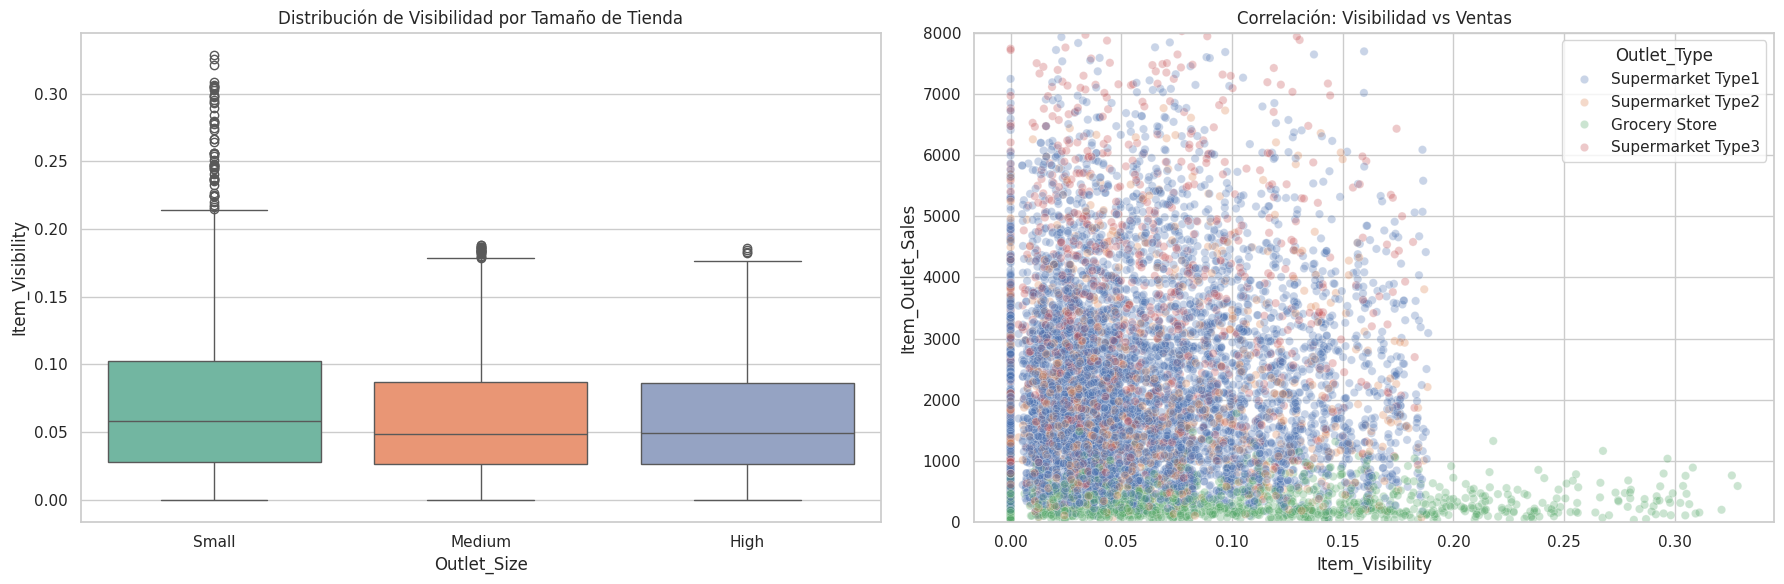

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 5.1 Tamaño vs Visibilidad Promedio
# Hipótesis: Tiendas chicas tienen menos espacio, ¿quizás muestran menos productos?
# O al revés: al tener menos productos, cada uno ocupa más % del total relativo.
sns.boxplot(x='Outlet_Size', y='Item_Visibility', data=df_merged, order=['Small', 'Medium', 'High'], ax=axes[0], palette='Set2')
axes[0].set_title('Distribución de Visibilidad por Tamaño de Tienda')

# 5.2 Visibilidad vs Ventas
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', hue='Outlet_Type', alpha=0.3, data=df_merged, ax=axes[1])
axes[1].set_title('Correlación: Visibilidad vs Ventas')
axes[1].set_ylim(0, 8000)

plt.tight_layout()
plt.show()

### Insights Operativos
1.  **Tamaño vs Visibilidad:** ¡Sorpresa! Las tiendas **Small** tienen una visibilidad promedio *mayor*. 
    * *Razón Técnica:* La visibilidad es un ratio (Espacio del producto / Espacio Total). En una tienda chica con menos inventario total, cada producto individual ocupa proporcionalmente más "atención" del cliente.
2.  **Visibilidad vs Ventas:** Existe una relación extraña. Muchos productos con alta visibilidad tienen ventas bajas (la "panza" de puntos azules/naranjas a la derecha). Esto suele indicar que dar mucha visibilidad a productos que no rotan es desperdicio de espacio.

---
## 6. Preferencias Geográficas (Tier vs Categoría)

¿Influye el tipo de ciudad en *qué* se vende más?

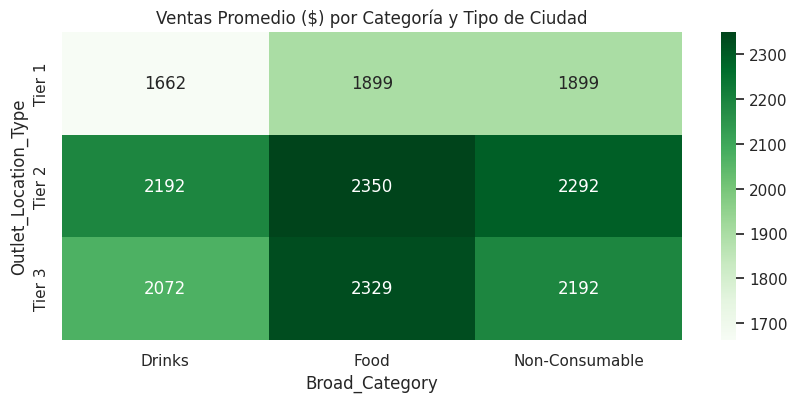

In [7]:
# Tabla pivote: Ventas Promedio por Categoría en cada Tier
tier_pref = df_merged.groupby(['Outlet_Location_Type', 'Broad_Category'])['Item_Outlet_Sales'].mean().unstack()

plt.figure(figsize=(10, 4))
sns.heatmap(tier_pref, annot=True, fmt='.0f', cmap='Greens')
plt.title('Ventas Promedio ($) por Categoría y Tipo de Ciudad')
plt.show()

### Insight Geográfico
Las preferencias son bastante estables. No se ve que Tier 1 prefiera drásticamente "Drinks" sobre Tier 3. Esto refuerza la teoría inicial: **El mercado es homogéneo en gustos, la diferencia la marca la capacidad operativa de la tienda (Supermarket Type 3 en Tier 3 arrasa).**

---
## 7. Generación del JSON Final para Dashboard

Consolidamos todo en un JSON. Incluiremos:
1.  **Perfil:** Ventas, Eficiencia, Año Estab, Ubicación.
2.  **Breakdown Clusters:** Valores y Porcentajes.
3.  **Insight Estratégico:** Tier de Precio Dominante.
4.  **Top Products:** Los 3 mejores SKUs.

In [8]:
# Función auxiliar para obtener Top Products
def get_top_items(df_subset, n=3):
    return df_subset.groupby(['Item_Identifier', 'Broad_Category'])['Item_Outlet_Sales'].sum() \
        .sort_values(ascending=False).head(n).reset_index().to_dict('records')

json_data = []

for store_id, row in df_dna.iterrows():
    # Subconjunto de datos para esta tienda
    subset = df_merged[df_merged['Outlet_Identifier'] == store_id]
    
    # Insight de Precio
    best_tier = subset.groupby('Price_Tier')['Item_Outlet_Sales'].mean().idxmax()
    
    store_obj = {
        "id": store_id,
        "type": row['Outlet_Type'],
        "size": str(row['Outlet_Size']),
        "location": row['Outlet_Location_Type'],
        "year_established": int(row['Outlet_Establishment_Year']),
        "total_sales": row['Total_Sales'],
        "dominant_price_tier": best_tier,
        "top_products": get_top_items(subset),
        "breakdown": []
    }
    
    # Breakdown de Clusters
    for cluster in cluster_cols:
        abs_val = row[cluster]
        pct_val = df_relative.loc[store_id, cluster]
        if abs_val > 0:
            store_obj['breakdown'].append({
                "cluster": cluster,
                "value": round(abs_val, 2),
                "percent": round(pct_val, 2)
            })
    
    json_data.append(store_obj)

output_path = '../Data/Processed/store_hierarchy_final.json'
with open(output_path, 'w') as f:
    json.dump(json_data, f, indent=4)

print(f"✅ JSON Final Generado: {output_path}")
print("Este archivo contiene la estructura completa para visualizar Mix, Escala, Top Items e Info de Entorno.")

✅ JSON Final Generado: ../Data/Processed/store_hierarchy_final.json
Este archivo contiene la estructura completa para visualizar Mix, Escala, Top Items e Info de Entorno.


## Resumen Final de la Notebook

Hemos completado el análisis integrando las dimensiones solicitadas:

1.  **Crecimiento:** Identificamos olas de apertura en 1985, 1997-1999 y 2000s.
2.  **Ubicación:** Tier 3 es el mercado más saturado y diverso.
3.  **Visibilidad:** Mayor en tiendas pequeñas (por ratio de espacio), pero no garantiza linealmente mayores ventas.
4.  **Estrategia de Precio:** Confirmamos que productos Premium tienen mejor rendimiento unitario en todos los formatos.
5.  **Output:** El archivo `store_hierarchy_final.json` está listo para ser la columna vertebral de tu Dashboard Web en la Fase E.